# PIP bitarray Tutorial

Fiber assign implementation of 
* https://arxiv.org/abs/1703.02070
* https://arxiv.org/abs/1809.07355


Based on the slides availabe here:

https://www.dropbox.com/s/zhw3m084f1w5cld/tskisner_fiberassign_20190129.pdf?dl=0


To create the input files, see: 

https://github.com/desihub/tutorials/blob/master/FiberAssignMocks.ipynb

Environment:
* 18.12 
* module swap fiberassign/1.0.0

In [1]:
import os, sys, copy, subprocess

In [2]:
import pylab                as     pl

In [3]:
import numpy                as     np

In [4]:
import matplotlib.pyplot    as     plt

In [49]:
##  pip install --user bitarray
from   bitarray             import bitarray

In [6]:
from   fiberassign.hardware import load_hardware

In [7]:
from   fiberassign.tiles    import load_tiles

In [8]:
from   fiberassign.targets  import (TARGET_TYPE_SCIENCE,
                                    TARGET_TYPE_SKY, 
                                    TARGET_TYPE_STANDARD,
                                    Targets,
                                    TargetsAvailable,
                                    TargetTree,
                                    FibersAvailable,
                                    load_target_file) 

In [58]:
from fiberassign.assign   import   Assignment
%matplotlib inline

In [57]:
##  Not available on NERSC Head node 
##  from mpi4py           import MPI

In [12]:
SCRATCH       = os.environ['SCRATCH']
root          = '/global/cscratch1/sd/mjwilson' + '/desi/test/fiberassign_mock/'

In [13]:
#  Read hardward properties;  See run_assign_init of https://github.com/desihub/fiberassign/blob/master/py/fiberassign/scripts/assign.py
hw            = load_hardware()

In [14]:
fibers        = np.array(hw.fiber_id)
nfiber        = len(fibers)

In [15]:
#  Read the Jaime's mock fiberassign example footprint.
tiles         = load_tiles(root + 'tiles.fits')

In [16]:
ntiles        = len(tiles.id)

In [17]:
tiles.id

[543,
 544,
 1587,
 6305,
 6306,
 7349,
 12065,
 12067,
 13111,
 17827,
 17829,
 18873,
 23589,
 24633,
 24635]

In [18]:
# Target files.  Get these from command line arguments, etc.
target_files  = ['mtl.fits', 'sky.fits', 'standards-dark.fits']

In [19]:
# Fiber assign realizations to do -- read these from a file or some other source. 
nrealizations = np.int(1)
realizations  = np.arange(nrealizations, dtype=np.int32)

In [20]:
##  How many MPI processes do we have and what is our rank?
##  mpi_procs = MPI.COMM_WORLD.size
##  mpi_rank  = MPI.COMM_WORLD.rank

In [43]:
# Load Target data.  There may be some contention from all MPI processes 
# reading at once, but this is only done once at the start of the job. 
tgs           = Targets()
 
for tgfile in target_files:
    load_target_file(tgs, root + tgfile)

In [23]:
##  Create a hierarchical triangle mesh lookup of the targets positions.
tree      = TargetTree(tgs) 

In [24]:
##  What iterations should this MPI rank compute? 
##  rank_realizations = np.array_split(realizations, mpi_procs)[mpi_rank]

In [25]:
##  Data structure of targets available to each fiber. 
tgsavail  = TargetsAvailable(hw, tgs, tiles, tree)

In [26]:
##  Find the number of unique targets, split by tile. 
untarget  = np.zeros(ntiles, dtype=np.int)

for i, tile in enumerate(tiles.id):
  ##  Returns the targets available for a given tile.  
  ##  Fiber ID as the key and the value is an array of 
  ##  target IDs available to the fiber.  
  tgsavail_tile  = tgsavail.tile_data(tile)
    
  for x in tgsavail_tile.values():    
    untarget[i] += len(x)    
    
    ##  assert np.all(np.diff(x) > 0)
    
  print(tile, untarget[i])

543 42694
544 44055
1587 42999
6305 43452
6306 43072
7349 41618
12065 43259
12067 43662
13111 42480
17827 42352
17829 43608
18873 43049
23589 37008
24633 38245
24635 38075


In [56]:
print('Total number of reachable targets is %d' % untarget.sum())

Total number of reachable targets is 629628


In [46]:
##  Available attributes for targets. 
dir(tgs)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'get',
 'ids']

In [63]:
##  Every MPI rank works on its own realizations. 
##  We run this job with one MPI rank per node and 
##  then use OpenMP and multiprocessing within a node.
result = []

for realization in realizations:
  ##  --  To do:  How to reseed sub-priorities for this realization.      
  ##
  ##  for id in tgs.ids:
  ##    props = tgs.get(id)
  ##    props.subpriority

  ##  Dithering our tile RA/DEC here.    
  ##  tiles = dither_tiles(nominal tiles, seed)
     
  # Compute the targets available to each fiber for each tile. 
  tgsavail  = TargetsAvailable(hw, tgs, tiles, tree)
   
  # Compute the fibers on all tiles available for each target. 
  favail    = FibersAvailable(tgsavail)

  ##  Create assignment object.
  asgn      = Assignment(tgs, tgsavail, favail)

  ##  First-pass assignment of science targets. 
  asgn.assign_unused(TARGET_TYPE_SCIENCE)

  ##  Redistribute science targets across available petals.
  asgn.redistribute_science()

  ##  Assign standards, 10 per petal. 
  asgn.assign_unused(TARGET_TYPE_STANDARD, 10)

  ##  Force assignment if needed
  asgn.assign_force(TARGET_TYPE_STANDARD, 10)

  ##  Assign sky, up to 40 per petal. 
  asgn.assign_unused(TARGET_TYPE_SKY, 40)
  asgn.assign_force(TARGET_TYPE_SKY, 40)
    
  ##  If there are any unassigned fibers, try to place them somewhere. 
  asgn.assign_unused(TARGET_TYPE_SCIENCE)
  asgn.assign_unused(TARGET_TYPE_SKY)
  
  _result = bitarray()
    
  ##  Loop over assigned tiles and update our bit array for this realization. 
  for i, tile in enumerate(tiles.id):    
    ##  Targets available to a fiber per tile.   
    _tgsavail_tile  = tgsavail.tile_data(tile)    
    
    ##  Concatenates split-by-fiber lists and sort. 
    tgsavail_tile   = np.sort(np.concatenate(list(_tgsavail_tile.values()))) 

    ##  Assigned target data. 
    tdata           = asgn.tile_fiber_target(tile)
       
    ##  We are updating only assigned targets, line 206 of https://github.com/desihub/fiberassign/blob/master/py/fiberassign/assign.py#L214
    tgids           = np.array(sorted([y for x, y in tdata.items()]), dtype=np.int64)

    ##  Find where in bitarrary that assigned id lives.   
    indices         = np.searchsorted(tgsavail_tile, tgids)
    
    ##  Binary array. 
    is_in           = np.zeros(untarget[i], dtype=np.int32)
    is_in[indices]  = 1        
    
    is_in           = ''.join(x for x in is_in.astype('str'))    

    ##  Binary of all available targets: sorted first by tiles, then by target_id.  
    _result.extend(is_in)
 
  result.append(_result)

In [ ]:
##  print(result)

In [61]:
##  Free the tree
##  del tree

Text(0,0.5,'DEC')

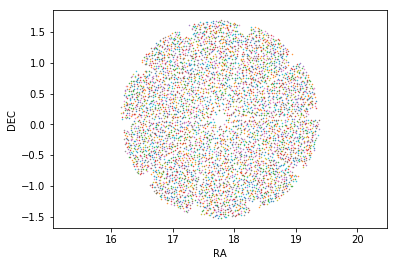

In [60]:
## Plot the last tile. 
for indx, tg in enumerate(tgids):
  props = tgs.get(tg)

  plt.scatter(props.ra, props.dec, s=0.2)

plt.axis('equal')

plt.xlabel('RA')
plt.ylabel('DEC')